# Quantum Support Vector Machine

This notebook is similar to `qsvm_haar_obs.ipynb`, but we use pennylane instead of qiskit for the quantum circuit.\
The same general observation are valid here so we suggest to first read that notebook and than come back here to have a implementation of a qsvm in pennylane.


In [10]:
# imports

import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, IQPEmbedding

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# Dataset
The features here are observables of a generated quantum state and the last column is the label telling us if the state is separable or entangled. To learn more about the generation of the various datasets we suggest to look at the `README` present in the datasets directory.

In [26]:
# Number of total exemples 
n_exemples = 400

# Loading dataset with pandas
dataset = pd.read_csv('../datasets/ds_haar_obs.csv')
dataset = dataset[:n_exemples]
dataset

,P11,P22,P33,P44,P13,P14,P24,P12,P23,P34,sep
0,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,True
1,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,True
2,0.176573,0.067155,0.055469,0.062003,0.256511,0.179351,0.105687,0.311796,0.154631,0.023350,False
3,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,True
4,0.139089,0.347255,0.249997,0.201476,0.491367,0.382842,0.488343,0.233877,0.272572,0.224575,False
...,...,...,...,...,...,...,...,...,...,...,...
395,0.405625,0.435526,0.357379,0.355404,0.163981,0.408181,0.325371,0.474474,0.363081,0.486966,False
396,0.492155,0.115941,0.315032,0.274306,0.195645,0.099904,0.423569,0.045464,0.252717,0.433526,False
397,0.421978,0.156901,0.410980,0.121906,0.475319,0.121317,0.497844,0.378980,0.162891,0.016753,False
398,0.191469,0.218936,0.463181,0.412639,0.428791,0.404222,0.332497,0.426629,0.019480,0.216316,False


In [27]:
# Number of features
n_features = 5

# Dividing dataset in features and label
X = dataset.to_numpy()[:,0:n_features]
y = dataset.to_numpy()[:,-1]

# Scaling the inputs 
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Redifining labels on -1,1
y_scaled = np.array(2 * (y - 0.5),dtype=int)

In [28]:
# Spliting dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,train_size=0.3)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 120
Test size: 280


# QSVM model

In [22]:
# Setting the number of qbits the same as the number of features
n_qubits = len(X_train[0])

dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

# Definition of the quantum kernel
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))


In [23]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

# Training and Testing

In [36]:
# Training of the model
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
# Accessing of the model
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

0.8571428571428571

In [58]:
from sklearn.metrics import roc_curve, auc

# Compute the decision function for the test set
pred = svm.decision_function(X_test)


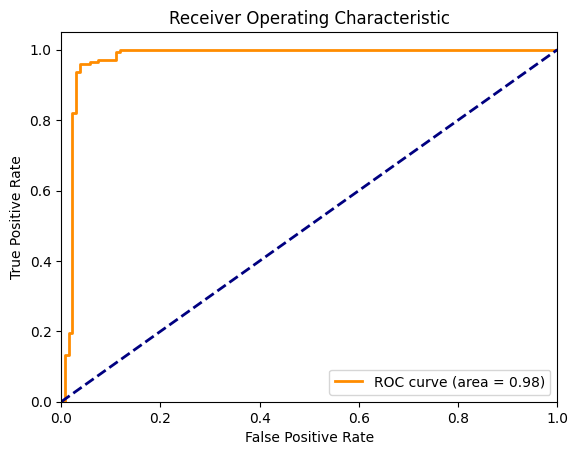

In [60]:
# Compute ROC curve and ROC area for the trained model
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

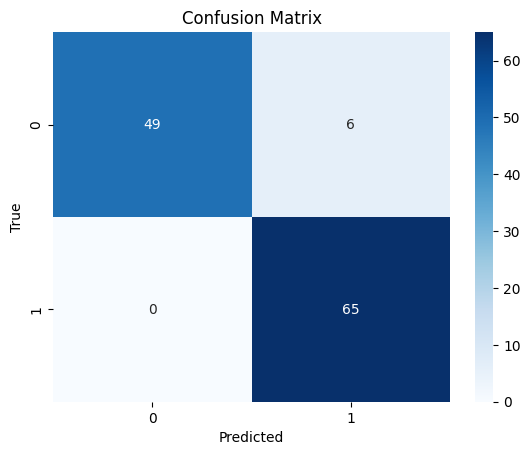

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Optional Encoding

In [41]:
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    IQPEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(IQPEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))


In [42]:
# Training of the model
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
# Accessing of the model
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

0.9666666666666667

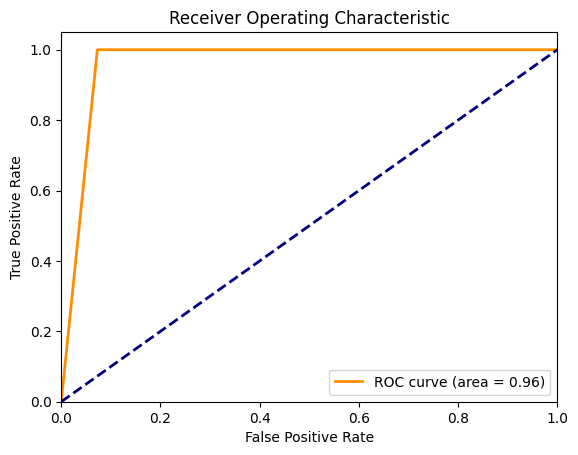

In [43]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the trained model
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

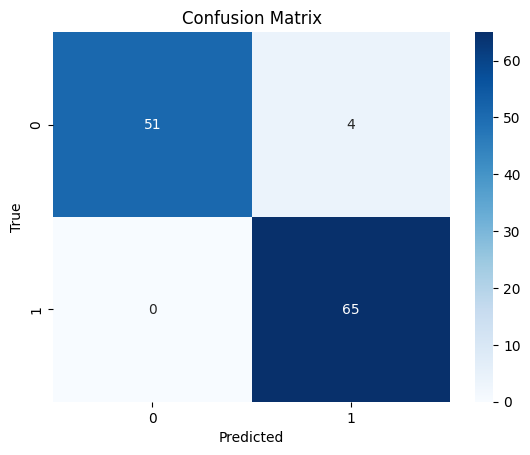

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
